<a href="https://colab.research.google.com/github/Rickkk2/BachelorThesis/blob/main/c_ProGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conexión con Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Módulos de Python**

In [ ]:
import re
import gc
import os
import cv2
import copy
import time
import pickle
import random
import shutil
import glob
import urllib
import pathlib
import datetime
import operator
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import albumentations as A

from PIL import Image
from scipy import linalg
from sklearn.metrics import *
from collections import Counter
from scipy.stats import truncnorm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import LabelEncoder

from skimage.io import imread

import torch
import torch as th
import torch.nn as nn
import torch.utils.data
import torchvision as tv
import torch.nn.functional as F
import torchvision.models as models

from torch.optim import Adam
from torch.nn import Parameter

from torchvision.datasets import *
from torch.autograd import Variable
from torch.optim.lr_scheduler import *
from torchvision.utils import save_image
from torchvision.datasets.folder import *
from torch.nn.functional import interpolate
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import Conv2d, BCEWithLogitsLoss, DataParallel, AvgPool2d, ModuleList, LeakyReLU, ConvTranspose2d, Embedding

begin = time.time()
sns.set_style('white')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

**Carga de los datos**

In [ ]:
#!zip -r "PALM-Training400.zip" "/content/drive/My Drive/Colab Notebooks/TFG/images/PALM-Training400"
#!zip -r "PALM-Training400-resized.zip" "/content/drive/My Drive/Colab Notebooks/TFG/images/PALM-Training400-resized"

!unzip "/content/drive/My Drive/Colab Notebooks/TFG/images/PALM-Training400.zip" -d "/content/PALM-Training400"
!unzip "/content/drive/My Drive/Colab Notebooks/TFG/images/PALM-Training400-transformed.zip" -d "/content/PALM-Training400-transformed"

Número de imágenes : 400


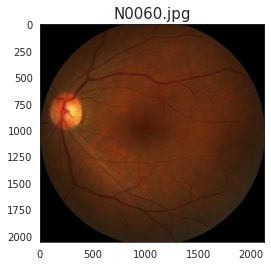

Dimensiones de la imagen - Ancho: 2124, Alto: 2056


In [ ]:
# Imágenes
DATA_PATH = '/content/PALM-Training400/PALM-Training400/'
# Imágenes pre-procesadas
DATA_TRANSFORMED_PATH = '/content/PALM-Training400-transformed/PALM-Training400-transformed/'
# Lista con las rutas absolutas de las imágenes iniciales
IMAGES = [DATA_PATH + p for p in os.listdir(DATA_PATH)]

# Modelos
GEN_PATH = '/content/drive/My Drive/Colab Notebooks/TFG/models/gen/'
GEN_SHADOW_PATH = '/content/drive/My Drive/Colab Notebooks/TFG/models/gen_shadow/'
DIS_PATH = '/content/drive/My Drive/Colab Notebooks/TFG/models/dis/'
OUTPUT = '/content/drive/My Drive/Colab Notebooks/TFG/images/output/'

print('Número de imágenes :', len(IMAGES))
imagen_prueba = Image.open(IMAGES[0])
plt.imshow(imagen_prueba)
plt.title(os.path.basename(IMAGES[0]), size=15)
plt.show()
print('Dimensiones de la imagen - Ancho: {}, Alto: {}'.format(imagen_prueba.size[0], imagen_prueba.size[1]))



**Preprocesado de las imágenes**

In [ ]:
# Transformaciones realizadas

'''
#files = glob.glob(DATA_PATH + "*.jpg")
transform = A.Compose(
    [A.Resize(1024, 1024), A.HorizontalFlip(p=0.5), A.Rotate(limit=10, p=1.0), A.GaussNoise(p=0.5), A.RandomBrightnessContrast(p=0.5), A.MotionBlur(p=0.5), A.RandomBrightnessContrast(p=0.5), A.CLAHE(p=0.5)  ]
)
# genera 50 imagenes nuevas por cada imagen; han de ser 50, buscar 7 o más transformaciones
num_images = 50
for f in IMAGES:
  nombre = os.path.basename(f)[:5]
  numero = nombre[1:5]
  letra = nombre[0]
  im = cv2.imread(f)
  #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  #plt.imshow(im)
  #plt.show()
  for i in range(num_images):
    transformed = transform(image=im)
    transformed_image = transformed["image"]
    cv2.imwrite(DATA_TRANSFORMED_PATH + nombre + "_" + str(i) + ".jpg", transformed_image)
    #plt.imshow(transformed_image)
    #plt.show()
'''


Número de imágenes transformadas: 20000


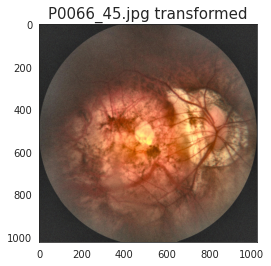

Dimensiones de la imagen transformada - Ancho: 1024, Alto: 1024


In [ ]:
TRANSFORMED_IMAGES = [DATA_TRANSFORMED_PATH + p for p in os.listdir(DATA_TRANSFORMED_PATH)]

print('Número de imágenes transformadas: ' + str(len(TRANSFORMED_IMAGES)))
imagen_prueba = Image.open(TRANSFORMED_IMAGES[0])
plt.imshow(imagen_prueba)
plt.title(os.path.basename(TRANSFORMED_IMAGES[0]) + " transformed", size=15)
plt.show()
print('Dimensiones de la imagen transformada - Ancho: {}, Alto: {}'.format(imagen_prueba.size[0], imagen_prueba.size[1]))

**Seeding**

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

In [ ]:
seed = 2021
seed_everything(seed)

**Inicialización del dataset**

In [ ]:
class MiopyDataset(Dataset):
    def __init__(self, img_list, labels):
        self.img_list = img_list # Lista con las imágenes pre-procesadas: ruta/imagen
        self.labels = labels

    def __getitem__(self, index):
        X = imread(self.img_list[index])
        X = np.moveaxis(X/255, -1, 0)
        y = self.labels[index]
        return torch.Tensor(X), y

    def __len__(self):
        return len(self.img_list)

In [ ]:
%%time
class_list = []
for f in os.listdir(DATA_TRANSFORMED_PATH):
  if f[0] == "P":
    class_list.append("PM")
  else:
    class_list.append("non-PM")

le = LabelEncoder().fit(class_list)
#print(le.classes_)
labels = le.transform(class_list)
dataset = MiopyDataset(TRANSFORMED_IMAGES, labels)
i = 2500
print("Imagen: " + TRANSFORMED_IMAGES[i])
print("Clase: " + class_list[i])
print("Etiqueta: " + str(labels[i]))

class_list_2 = ["PM", "non-PM"]

# Esta es la parte de prueba del TEST_20
#dataset_20 = MiopyDataset(TEST_20, LabelEncoder().fit(TEST_20_class).transform(TEST_20_class))
#i = 1
#print("Imagen: " + TEST_20[i])
#print("Clase: " + TEST_20_class[i])
#print("Etiqueta: " + str(LabelEncoder().fit(TEST_20_class).transform(TEST_20_class)[i]))



Imagen: /content/PALM-Training400-transformed/PALM-Training400-transformed/P0005_20.jpg
Clase: PM
Etiqueta: 0
CPU times: user 28.5 ms, sys: 9.18 ms, total: 37.6 ms
Wall time: 39.7 ms


**Spectral Normalization**

In [ ]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

**Equalized Layers**

In [ ]:
# extending Conv2D and Deconv2D layers for equalized learning rate logic
class _equalized_conv2d(th.nn.Module):
    """ conv2d with the concept of equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out:  output channels
            :param k_size: kernel size (h, w) should be a tuple or a single integer
            :param stride: stride for conv
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        from torch.nn.modules.utils import _pair
        from numpy import sqrt, prod

        super(_equalized_conv2d, self).__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_out, c_in, *_pair(k_size))
        ))

        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = prod(_pair(k_size)) * c_in  # value of fan_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the network
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import conv2d

        return conv2d(input=x,
                      weight=self.weight * self.scale,  # scale the weight on runtime
                      bias=self.bias if self.use_bias else None,
                      stride=self.stride,
                      padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class _equalized_deconv2d(th.nn.Module):
    """ Transpose convolution using the equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out: output channels
            :param k_size: kernel size
            :param stride: stride for convolution transpose
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        from torch.nn.modules.utils import _pair
        from numpy import sqrt

        super(_equalized_deconv2d, self).__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_in, c_out, *_pair(k_size))
        ))

        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in  # value of fan_in for deconv
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import conv_transpose2d

        return conv_transpose2d(input=x,
                                weight=self.weight * self.scale,  # scale the weight on runtime
                                bias=self.bias if self.use_bias else None,
                                stride=self.stride,
                                padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class _equalized_linear(th.nn.Module):
    """ Linear layer using equalized learning rate
        Args:
            :param c_in: number of input channels
            :param c_out: number of output channels
            :param bias: whether to use bias with the linear layer
    """

    def __init__(self, c_in, c_out, bias=True):
        """
        Linear layer modified for equalized learning rate
        """
        from numpy import sqrt

        super(_equalized_linear, self).__init__()

        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_out, c_in)
        ))

        self.use_bias = bias

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import linear
        return linear(x, self.weight * self.scale,
                      self.bias if self.use_bias else None)

**Pixelwise Normalization**

In [ ]:
class PixelwiseNorm(th.nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

**Minibatch Standard Deviation**

In [ ]:
class MinibatchStdDev(th.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """
    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape

        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)

        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size, 1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)

        # return the computed values:
        return y

**Bloques del Generador**

In [ ]:
class GenInitialBlock(th.nn.Module):
    def __init__(self, in_channels, use_eql, use_spec_norm=False):
        super(GenInitialBlock, self).__init__()

        if use_eql:
            self.conv_1 = _equalized_deconv2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)

        else:
            self.conv_1 = ConvTranspose2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)

        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)

        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        # convert the tensor shape:
        y = th.unsqueeze(th.unsqueeze(x, -1), -1)

        # perform the forward computations:
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))
        y = self.pixNorm(y)

        return y

In [ ]:
class GenGeneralConvBlock(th.nn.Module):
    def __init__(self, in_channels, out_channels, use_eql, use_spec_norm=False):
        super(GenGeneralConvBlock, self).__init__()

        self.upsample = lambda x: interpolate(x, scale_factor=2)

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, out_channels, (3, 3),
                                            pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(out_channels, out_channels, (3, 3),
                                            pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, out_channels, (3, 3),
                                 padding=1, bias=True)
            self.conv_2 = Conv2d(out_channels, out_channels, (3, 3),
                                 padding=1, bias=True)

        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)

        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the block
        :param x: input
        :return: y => output
        """
        y = self.upsample(x)
        y = self.pixNorm(self.lrelu(self.conv_1(y)))
        y = self.pixNorm(self.lrelu(self.conv_2(y)))

        return y

**Bloques del Discriminante**

In [ ]:
class DisGeneralConvBlock(th.nn.Module):
    """ General block in the discriminator  """

    def __init__(self, in_channels, out_channels, use_eql, use_spec_norm=False):
        """
        constructor of the class
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        :param use_eql: whether to use equalized learning rate
        """
        super(DisGeneralConvBlock, self).__init__()

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, out_channels, (3, 3), pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, out_channels, (3, 3), padding=1, bias=True)

        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)

        self.downSampler = AvgPool2d(2)
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        y = self.lrelu(self.conv_1(x))
        y = self.lrelu(self.conv_2(y))
        y = self.downSampler(y)
        return y

In [ ]:
class ConDisFinalBlock(th.nn.Module):
    def __init__(self, in_channels, num_classes, use_eql):
        super(ConDisFinalBlock, self).__init__()

        # declare the required modules for forward pass
        self.batch_discriminator = MinibatchStdDev()
        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels + 1, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = _equalized_conv2d(in_channels, 1, (1, 1), bias=True)
        else:
            self.conv_1 = Conv2d(in_channels + 1, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = Conv2d(in_channels, 1, (1, 1), bias=True)

        # we also need an embedding matrix for the label vectors
        self.label_embedder = Embedding(num_classes, in_channels, max_norm=1)

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

        # for ft matching
        nb_ft = 128
        self.ft_matching_dense = nn.Linear(2 * in_channels, nb_ft)

    def forward(self, x, labels, return_ft=False):
        """
        forward pass of the FinalBlock
        :param x: input
        :param labels: samples' labels for conditional discrimination
                       Note that these are pure integer labels [Batch_size x 1]
        :return: y => output
        """
        batch_size = x.size()[0]
        # minibatch_std_dev layer
        y = self.batch_discriminator(x)  # [B x C x 4 x 4]

        # perform the forward pass
        y = self.lrelu(self.conv_1(y))  # [B x C x 4 x 4]

        # obtain the computed features
        y = self.lrelu(self.conv_2(y))  # [B x C x 1 x 1]
        y_ = y.view((batch_size, -1))  # [B x C]

        # embed the labels
        labels = self.label_embedder(labels.cuda()).view((batch_size, -1))  # [B x C]

        # compute the inner product with the label embeddings

        if return_ft:
            self.ft_matching_dense(torch.cat((y_, labels), 1))

        projection_scores = (y_ * labels).sum(dim=-1)  # [B]

        # normal discrimination score
        y = self.lrelu(self.conv_3(y))  # This layer has linear activation

        # calculate the total score
        final_score = y.view(-1) + projection_scores

        # return the output raw discriminator scores
        return final_score

**Gaussian Noise**

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma
        self.noise = torch.tensor(0).cuda()

    def forward(self, x):
        if self.training:
            noise = self.noise.repeat(*x.size()).float().normal_() * self.sigma #self.sigma * x?
            return x + noise
        return x

**Generador**

In [ ]:
class Generator(nn.Module):
    def __init__(self, depth=5, latent_size=128, use_eql=True, use_spec_norm=False):
        super(Generator, self).__init__()

        assert latent_size != 0 and ((latent_size & (latent_size - 1)) == 0), "latent size not a power of 2"
        if depth >= 4: assert latent_size >= np.power(2, depth - 4), "latent size will diminish to zero"

        self.use_eql = use_eql
        self.use_spec_norm = use_spec_norm
        self.depth = depth
        self.latent_size = latent_size

        # register the modules required for the GAN
        self.initial_block = GenInitialBlock(self.latent_size, use_eql=self.use_eql, use_spec_norm=False)

        # create a module list of the other required general convolution blocks
        self.layers = ModuleList([])  # initialize to empty list

        # create the ToRGB layers for various outputs:
        if self.use_eql:
            self.toRGB = lambda in_channels: _equalized_conv2d(in_channels, 3, (1, 1), bias=True)
        else:
            self.toRGB = lambda in_channels: Conv2d(in_channels, 3, (1, 1), bias=True)

        self.rgb_converters = ModuleList([self.toRGB(self.latent_size)])

        # create the remaining layers
        for i in range(self.depth - 1):
            if i <= 2:
                layer = GenGeneralConvBlock(self.latent_size, self.latent_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm)
                rgb = self.toRGB(self.latent_size)
            else:
                in_size = int(self.latent_size // np.power(2, i - 3))
                out_size = int(self.latent_size // np.power(2, i - 2))

                layer = nn.Sequential(
                    GenGeneralConvBlock(in_size, out_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     Self_Attn(out_size)
                )
                rgb = self.toRGB(out_size)

            self.layers.append(layer)
            self.rgb_converters.append(rgb)

        # register the temporary upsampler
        self.temporaryUpsampler = lambda x: interpolate(x, scale_factor=2)
        self.tanh = nn.Tanh()

    def forward(self, x, depth, alpha):
        assert depth < self.depth, "Requested output depth cannot be produced"

        y = self.initial_block(x)

        if depth > 0:
            for block in self.layers[:depth - 1]:
                y = block(y)

            residual = self.rgb_converters[depth - 1](self.temporaryUpsampler(y))
            straight = self.rgb_converters[depth](self.layers[depth - 1](y))

            out = (alpha * straight) + ((1 - alpha) * residual)

        else:
            out = self.rgb_converters[0](y)

        return self.tanh(out)

**Discriminante**

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, height=7, feature_size=512, use_eql=True, use_spec_norm=False):
        super(ConditionalDiscriminator, self).__init__()

        assert feature_size != 0 and ((feature_size & (feature_size - 1)) == 0), "latent size not a power of 2"
        if height >= 4:
            assert feature_size >= np.power(2, height - 4), "feature size cannot be produced"

        # create state of the object
        self.use_eql = use_eql
        self.use_spec_norm = use_spec_norm
        self.height = height
        self.feature_size = feature_size
        self.num_classes = num_classes

        self.noise = GaussianNoise(sigma=0.2)
        self.final_block = ConDisFinalBlock(self.feature_size, self.num_classes, use_eql=self.use_eql)

        # create a module list of the other required general convolution blocks
        self.layers = ModuleList([])  # initialize to empty list

        # create the fromRGB layers for various inputs:
        if self.use_eql:
            self.fromRGB = lambda out_channels: _equalized_conv2d(3, out_channels, (1, 1), bias=True)
        else:
            self.fromRGB = lambda out_channels: Conv2d(3, out_channels, (1, 1), bias=True)

        rgb = self.fromRGB(self.feature_size)
        if use_spec_norm:
            rgb = SpectralNorm(rgb)
        self.rgb_to_features = ModuleList([rgb])

        # create the remaining layers
        for i in range(self.height - 1):
            if i > 2:
                in_size = int(self.feature_size // np.power(2, i - 2))
                out_size = int(self.feature_size // np.power(2, i - 3))
                layer = nn.Sequential(
                    DisGeneralConvBlock(in_size, out_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     self.noise,
                )

                rgb = self.fromRGB(in_size)

            else:
                layer = nn.Sequential(
                    DisGeneralConvBlock(self.feature_size, self.feature_size,  use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     self.noise,
                )
                rgb = self.fromRGB(self.feature_size)

            if use_spec_norm:
                rgb = SpectralNorm(rgb)

            self.layers.append(layer)
            self.rgb_to_features.append(rgb)

        # register the temporary downSampler
        self.temporaryDownsampler = AvgPool2d(2)

    def forward(self, x, labels, height, alpha, return_ft=False):
        assert height < self.height, "Requested output depth cannot be produced"

        if height > 0:
            residual = self.rgb_to_features[height - 1](self.temporaryDownsampler(x))

            straight = self.layers[height - 1](
                self.rgb_to_features[height](x)
            )

            y = (alpha * straight) + ((1 - alpha) * residual)

            for block in reversed(self.layers[:height - 1]):
                y = block(y)
        else:
            y = self.rgb_to_features[0](x)

        out = self.final_block(y, labels, return_ft=return_ft)
        return out

**Coste**

In [ ]:
class ConditionalGANLoss:
    """ Base class for all conditional losses """
    def __init__(self, dis):
        self.dis = dis

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        raise NotImplementedError("dis_loss method has not been implemented")

    def gen_loss(self, real_samps, fake_samps, labels, height, alpha):
        raise NotImplementedError("gen_loss method has not been implemented")

In [ ]:
class StandardLoss(ConditionalGANLoss):
    def __init__(self, dis):
        super().__init__(dis)
        self.criterion = BCEWithLogitsLoss(reduction='sum')

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        assert real_samps.device == fake_samps.device, "Different devices"

        preds_real = self.dis(real_samps, labels, height, alpha)
        preds_fake = self.dis(fake_samps, labels, height, alpha)

        labels_real = torch.from_numpy(np.random.uniform(0.5, 0.99, real_samps.size()[0])).float().cuda()
        labels_fake = torch.from_numpy(np.random.uniform(0, 0.25, fake_samps.size()[0])).float().cuda()

        real_loss = self.criterion(preds_real.view(-1), labels_real)
        fake_loss = self.criterion(preds_fake.view(-1), labels_fake)

        return real_loss + fake_loss

    def gen_loss(self, _, fake_samps, labels, height, alpha):
        preds_fake = self.dis(fake_samps, labels, height, alpha)
        labels_real = torch.from_numpy(np.random.uniform(0.5, 0.99, fake_samps.size()[0])).float().cuda()
        return self.criterion(preds_fake.view(-1), labels_real)

In [ ]:
class Hinge(ConditionalGANLoss):
    def __init__(self, dis):
        super().__init__(dis)

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        r_preds = self.dis(real_samps, labels, height, alpha)
        f_preds = self.dis(fake_samps, labels, height, alpha)
        loss = (torch.mean(th.nn.ReLU()(1 - r_preds)) + torch.mean(th.nn.ReLU()(1 + f_preds)))
        return loss

    def gen_loss(self, _, fake_samps, labels, height, alpha):
        return - torch.mean(self.dis(fake_samps, labels, height, alpha))

**EMA Weights Decay**

In [ ]:
def update_average(model_old, model_new, beta):
    def toggle_grad(model, requires_grad):
        for p in model.parameters():
            p.requires_grad_(requires_grad)

    toggle_grad(model_old, False)
    toggle_grad(model_new, False)

    param_dict_new = dict(model_new.named_parameters())
    for param_name, param_old in model_old.named_parameters():
        param_new = param_dict_new[param_name]
        assert (param_old is not param_new)
        param_old.copy_(beta * param_old + (1. - beta) * param_new)

    toggle_grad(model_old, True)
    toggle_grad(model_new, True)

**Red**

In [ ]:
class ConditionalProGAN:
    def __init__(self, num_classes=2, depth=7, latent_size=128, embed_dim=64,
                 lr_g=0.001, lr_d=0.001, n_critic=1, use_eql=True, use_spec_norm=False,
                 loss=StandardLoss, use_ema=True, ema_decay=0.999):

        self.gen = Generator(depth=depth, latent_size=latent_size,
                             use_eql=use_eql, use_spec_norm=False).cuda()
        self.dis = ConditionalDiscriminator(num_classes, height=depth, feature_size=latent_size,
                                            use_eql=use_eql, use_spec_norm=use_spec_norm).cuda()

        self.gen = DataParallel(self.gen)
        self.dis = DataParallel(self.dis)

        self.latent_size = latent_size
        self.num_classes = num_classes
        self.depth = depth

        self.use_ema = use_ema
        self.ema_decay = ema_decay
        self.n_critic = n_critic
        self.use_eql = use_eql
        self.drift = 0.001

        self.lr_g = lr_g
        self.lr_d = lr_d

        self.gen_optim = Adam(self.gen.parameters(), lr=self.lr_g, betas=(0.5, 0.99), eps=1e-8)
        self.dis_optim = Adam(self.dis.parameters(), lr=self.lr_d, betas=(0.5, 0.99), eps=1e-8)

        try:
            self.loss = loss(self.dis)
        except:
            self.loss = loss(self.dis, drift=self.drift, use_gp=True)

        # setup the ema for the generator
        if self.use_ema:
            self.gen_shadow = copy.deepcopy(self.gen)
            self.ema_updater = update_average
            self.ema_updater(self.gen_shadow, self.gen, beta=0)


    def __progressive_downsampling(self, real_batch, depth, alpha):
        """
        private helper for downsampling the original images in order to facilitate the
        progressive growing of the layers.
        :param real_batch: batch of real samples
        :param depth: depth at which training is going on
        :param alpha: current value of the fader alpha
        :return: real_samples => modified real batch of samples
        """

        # downsample the real_batch for the given depth
        down_sample_factor = int(np.power(2, self.depth - depth - 1))
        prior_downsample_factor = max(int(np.power(2, self.depth - depth)), 0)

        ds_real_samples = AvgPool2d(down_sample_factor)(real_batch)

        if depth > 0:
            prior_ds_real_samples = interpolate(AvgPool2d(prior_downsample_factor)(real_batch),
                                                scale_factor=2)
        else:
            prior_ds_real_samples = ds_real_samples

        # real samples are a combination of ds_real_samples and prior_ds_real_samples
        real_samples = (alpha * ds_real_samples) + ((1 - alpha) * prior_ds_real_samples)

        # return the so computed real_samples
        return real_samples


    def optimize_discriminator(self, noise, real_batch, labels, depth, alpha):
        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)
        loss_val = 0

        for _ in range(self.n_critic):
            fake_samples = self.gen(noise, depth, alpha).detach()
            loss = self.loss.dis_loss(real_samples, fake_samples, labels, depth, alpha)

            self.dis_optim.zero_grad()
            loss.backward()
            self.dis_optim.step()

            loss_val += loss.item()

        return loss_val / self.n_critic


    def optimize_generator(self, noise, real_batch, labels, depth, alpha):
        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)
        fake_samples = self.gen(noise, depth, alpha)

        loss = self.loss.gen_loss(real_samples, fake_samples, labels, depth, alpha)

        self.gen_optim.zero_grad()
        loss.backward()
        self.gen_optim.step()

        if self.use_ema:
            self.ema_updater(self.gen_shadow, self.gen, self.ema_decay)

        return loss.item()


    def one_hot_encode(self, labels):
        if not hasattr(self, "label_oh_encoder"):
            self.label_oh_encoder = th.nn.Embedding(self.num_classes, self.num_classes)
            self.label_oh_encoder.weight.data = th.eye(self.num_classes)
        return self.label_oh_encoder(labels.view(-1))


    @staticmethod
    def scale(imgs):
        def norm(img, inf, sup):
            img.clamp_(min=inf, max=sup)
            img.add_(-inf).div_(sup - inf + 1e-5)

        for img in imgs:
            norm(img, float(img.min()), float(img.max()))
        # ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()


    @staticmethod
    def truncated_normal(size, threshold=1):
        values = truncnorm.rvs(-threshold, threshold, size=size)
        return values


    def generate(self, depth=None, alpha=1, noise=None, races=None, n=64, n_plot=0):
        if depth is None:
            depth = self.depth - 1
        if noise is None:
            noise = th.randn(n, self.latent_size - self.num_classes).cuda()
#             z = self.truncated_normal(size=(n, self.latent_size - self.num_classes))
#             noise = torch.from_numpy(z).float().cuda()
        if races is None:
            races = torch.from_numpy(np.random.choice(range(self.num_classes), size=n)).long()

        label_information = self.one_hot_encode(races).cuda()
        gan_input = th.cat((label_information, noise), dim=-1)

        if self.use_ema:
            generated_images = self.gen_shadow(gan_input, depth, alpha).detach().cpu()
        else:
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()

#         self.scale(generated_images)
        generated_images.add_(1).div_(2)
        images = generated_images.clone().numpy().transpose(0, 2, 3, 1)

        if n_plot >= 5:
            plt.figure(figsize=(15, 3 * n_plot//5))
            for i in range(n_plot):
                plt.subplot(n_plot//5, 5, i+1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(class_list_2[races.cpu().numpy()[i]])
            plt.show()
        return generated_images


    def generate_score(self, depth=None, alpha=1, noise=None, races=None, n=64, n_plot=0):
        if depth is None:
            depth = self.depth - 1
        if noise is None:
            noise = th.randn(n, self.latent_size - self.num_classes).cuda()
        if races is None:
            races = torch.from_numpy(np.random.choice(range(self.num_classes), size=n)).long()

        label_information = self.one_hot_encode(races).cuda()
        gan_input = th.cat((label_information, noise), dim=-1)

        if self.use_ema:
            generated_images = self.gen_shadow(gan_input, depth, alpha).detach().cpu()
        else:
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()

        generated_images.add_(1).div_(2)
        images = generated_images.clone().numpy().transpose(0, 2, 3, 1)
        scores = nn.Sigmoid()(self.dis(generated_images, races, depth, alpha)).cpu().detach().numpy()

        if n_plot >= 5:
            plt.figure(figsize=(15, 3 * n_plot//5))
            for i in range(n_plot):
                plt.subplot(n_plot//5, 5, i+1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(class_list_2[races.cpu().numpy()[i]] + f' - {scores[i]:.3f}' )
            plt.show()

        return images, generated_images, scores, races.cpu().numpy()


    def plot_race(self, race_idx, depth=4, alpha=1, n_plot=5, n=128):
        races = np.concatenate((np.array([race_idx]* n_plot),
                                np.random.choice(range(self.num_classes), size=n - n_plot)))

        races = torch.from_numpy(races).long()
        self.generate(depth, alpha=alpha, races=races, n=n, n_plot=n_plot)


    def compute_mifid(self, alpha=1, folder='../tmp_images', n_images=10000, im_batch_size=100):
        if os.path.exists(folder):
            shutil.rmtree(folder, ignore_errors=True)
        os.mkdir(folder)

        for i_b in range(0, n_images, im_batch_size):
            gen_images = self.generate(n=im_batch_size)
            for i_img in range(gen_images.size(0)):
                save_image(gen_images[i_img, :, :, :], os.path.join(folder, f'img_{i_b+i_img}.png'))

        if len(os.listdir('../tmp_images')) != n_images:
            print(len(os.listdir('../tmp_images')))

        mifid = compute_mifid(folder, DATA_TRANSFORMED_PATH, WEIGHTS_PATH, model_params) # antes ponia DATA_PATH
        shutil.rmtree(folder, ignore_errors=True)
        return mifid


    def train(self, dataset, epochs, batch_sizes, fade_in_percentage, ema_decays, start_depth=0, verbose=1):
        assert self.depth == len(batch_sizes), "batch_sizes not compatible with depth"
        infos = {'resolution': [], 'discriminator_loss': [], 'generator_loss': []}
        self.gen.train()
        self.dis.train()
        if self.use_ema:
            self.gen_shadow.train()

        fixed_noise = torch.randn(128, self.latent_size - self.num_classes).cuda()
        fixed_races = torch.from_numpy(np.random.choice(range(self.num_classes), size=128)).long()

        for current_depth in range(start_depth, self.depth):
            current_res = np.power(2, current_depth + 2)
            print("\n   -> Current resolution: %d x %d \n" % (current_res, current_res))

            data = torch.utils.data.DataLoader(dataset, batch_size=batch_sizes[current_depth], num_workers=4, shuffle=True)
            self.ema_decay = ema_decays[current_depth]
            ticker = 1




            for epoch in range(1, epochs[current_depth] + 1):
                start_time = time.time()
                d_loss = 0
                g_loss = 0

                fader_point = fade_in_percentage[current_depth] // 100 * epochs[current_depth] * len(iter(data))
                step = 0  # counter for number of iterations

                if current_res == 64 and (epoch % 50) == 0:
                    self.ema_decay = 0.9 + self.ema_decay / 10


                for (i, batch) in enumerate(data, 1):
                    # calculate the alpha for fading in the layers
                    alpha = ticker / fader_point if ticker <= fader_point else 1

                    # extract current batch of data for training
                    images, labels = batch
                    images = images.cuda()
                    labels = labels.view(-1, 1)

                    # create the input to the Generator
                    label_information = self.one_hot_encode(labels).cuda()
                    latent_vector = th.randn(images.shape[0], self.latent_size - self.num_classes).cuda()
                    gan_input = th.cat((label_information, latent_vector), dim=-1)

                    # optimize the discriminator:
                    dis_loss = self.optimize_discriminator(gan_input, images,
                                                           labels, current_depth, alpha)
                    d_loss += dis_loss / len(data)

                    # optimize the generator:
                    gen_loss = self.optimize_generator(gan_input, images,
                                                       labels, current_depth, alpha)
                    g_loss += gen_loss / len(data)

                    # increment the alpha ticker and the step
                    ticker += 1
                    step += 1

                infos['discriminator_loss'].append(d_loss)
                infos['generator_loss'].append(g_loss)
                infos['resolution'].append(current_res)


                ## GUARDAR EL MODELO
                '''
                Antes de guardar, se examinan los directorios para comprobar el número de archivos de tipo.
                Si por alguna razón la ejecución se interrumpió antes de tiempo, el siguiente a guardar será el inmediatamente superior al menor que los tres modelos compartan.
                Ejemplo: gen_num=2, gen_shadow_num=2, dis_num=1. num=1, así que guardaremos los archivos .pt desde el 2 (sobreescribiendo los ya existentes)
                '''
                gen_num = len(os.listdir(GEN_PATH))
                gen_shadow_num = len(os.listdir(GEN_SHADOW_PATH))
                dis_num = len(os.listdir(DIS_PATH))
                num = min(gen_num, gen_shadow_num, dis_num)

                torch.save({'epoch': epoch, 'current_depth': current_depth, 'model_state_dict': self.gen.state_dict()}, GEN_PATH + "gen_weights" + str(num+1).zfill(6) + ".pt")
                torch.save({'epoch': epoch, 'current_depth': current_depth, 'model_state_dict': self.gen_shadow.state_dict()}, GEN_SHADOW_PATH + "gen_shadow_weights" + str(num+1).zfill(6) + ".pt")
                torch.save({'epoch': epoch, 'current_depth': current_depth, 'model_state_dict': self.dis.state_dict()}, DIS_PATH + "dis_weights" + str(num+1).zfill(6) + ".pt")


                if epoch % verbose == 0:
                    elapsed_time = time.time() - start_time
                    print(f'Epoch {epoch}/{epochs[current_depth]}     lr_g={self.lr_g:.1e}     lr_d={self.lr_d:.1e}     ema_decay={self.ema_decay:.4f}', end='     ')
                    print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')
                '''
                if epoch % (verbose * 25) == 0 and current_res == 64:
                    for i in range(5):
                        self.plot_race(i, depth=current_depth, alpha=alpha, n_plot=5, n=batch_sizes[0])
#                     score = self.compute_mifid(alpha=alpha)
#                     print(f'\n -> MiFID at epoch {epoch} is {score:.3f} \n')
                    seed_everything(seed + epoch)
                '''
                if epoch % (verbose * 10) == 0:
                    pm = torch.from_numpy(np.random.choice([0], size=batch_sizes[0])).long()
                    nonpm = torch.from_numpy(np.random.choice([1], size=batch_sizes[0])).long()
                    my_noise = th.randn(batch_sizes[0], self.latent_size - self.num_classes).cuda()
                    img_pm = self.generate(current_depth, alpha=alpha, noise=my_noise, races=pm, n=batch_sizes[0], n_plot=20)
                    img_nonpm = self.generate(current_depth, alpha=alpha, noise=my_noise, races=nonpm, n=batch_sizes[0], n_plot=20)


                    for j in range(img_pm.size(0)):
                      out_num = len(os.listdir(OUTPUT))
                      save_image(img_pm[j, :, :, :], OUTPUT + "img" + str(out_num + 1) + "_" + class_list_2[pm.cpu().numpy()[j]] + "_epoch" + str(num+1) + ".png") # Por ejemplo: img1_PM_epoch30

                    for v in range(img_nonpm.size(0)):
                      out_num = len(os.listdir(OUTPUT))
                      save_image(img_nonpm[v, :, :, :], OUTPUT + "img" + str(out_num + 1) + "_" + class_list_2[nonpm.cpu().numpy()[v]] + "_epoch" + str(num+1) + ".png") # Por ejemplo: img2_nonPM_epoch50


                #if time.time() - KERNEL_START_TIME > 32000:
                    #print('Time limit reached, interrupting training.')
                    #break



        self.gen.eval()
        self.dis.eval()
        if self.use_ema:
            self.gen_shadow.eval()
        return infos

**Entrenamiento**

In [ ]:
seed_everything(seed)

In [ ]:
depth = 9
latent_size = 256

In [ ]:
#loss = Hinge
loss = StandardLoss
lr_d = 6e-3
lr_g = 6e-3

In [ ]:
pro_gan = ConditionalProGAN(num_classes=2, depth=depth, latent_size=latent_size,
                            loss=loss, lr_d=lr_d, lr_g=lr_g,
                            use_ema=True, use_eql=True, use_spec_norm=False)

In [ ]:
num_epochs = [10, 10, 20, 40, 100, 200, 500, 1000, 2000]
fade_ins = [50, 20, 20, 10, 5, 5, 5, 5, 5]
batch_sizes = [20] * 9
ema_decays = [0.9, 0.9, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]

In [ ]:
# CARGA DEL MODELO. LA PRIMERA VEZ NO SE EJECUTA. LAS DEMÁS SÍ
'''
def extract_number(f):
    s = re.findall("\d+$",f)
    return (int(s[0]) if s else -1,f)


if len(os.listdir(GEN_PATH)) != 0 :
  lastVersionGen = max([GEN_PATH + p for p in os.listdir(GEN_PATH)],key=extract_number)
  print(lastVersionGen)
  checkpointGen = torch.load(lastVersionGen)
  pro_gan.gen.load_state_dict(checkpointGen['model_state_dict'])
  num_epochs[checkpointGen['current_depth']] = num_epochs[checkpointGen['current_depth']] - checkpointGen['epoch']
  for i, val in enumerate(num_epochs):
    if i < checkpointGen['current_depth']:
      num_epochs[i] = 0
if len(os.listdir(GEN_SHADOW_PATH)) != 0 :
  lastVersionGenSh = max([GEN_SHADOW_PATH + p for p in os.listdir(GEN_SHADOW_PATH)],key=extract_number)
  print(lastVersionGenSh)
  checkpointGenSh = torch.load(lastVersionGenSh)
  pro_gan.gen_shadow.load_state_dict(checkpointGenSh['model_state_dict'])
if len(os.listdir(DIS_PATH)) != 0 :
  lastVersionDis = max([DIS_PATH + p for p in os.listdir(DIS_PATH)],key=extract_number)
  print(lastVersionDis)
  checkpointDis = torch.load(lastVersionDis)
  pro_gan.dis.load_state_dict(checkpointDis['model_state_dict'])
'''

gen_num = len(os.listdir(GEN_PATH))
gen_shadow_num = len(os.listdir(GEN_SHADOW_PATH))
dis_num = len(os.listdir(DIS_PATH))
num = 10

lastVersionGen = GEN_PATH + "gen_weights" + str(num).zfill(6) + ".pt"
print(lastVersionGen)
checkpointGen = torch.load(lastVersionGen)
pro_gan.gen.load_state_dict(checkpointGen['model_state_dict'])
num_epochs[checkpointGen['current_depth']] = num_epochs[checkpointGen['current_depth']] - checkpointGen['epoch']
for i, val in enumerate(num_epochs):
    if i < checkpointGen['current_depth']:
      num_epochs[i] = 0

lastVersionGenSh = GEN_SHADOW_PATH + "gen_shadow_weights" + str(num).zfill(6) + ".pt"
print(lastVersionGenSh)
checkpointGenSh = torch.load(lastVersionGenSh)
pro_gan.gen_shadow.load_state_dict(checkpointGenSh['model_state_dict'])

lastVersionDis = DIS_PATH + "dis_weights" + str(num).zfill(6) + ".pt"
print(lastVersionDis)
checkpointDis = torch.load(lastVersionDis)
pro_gan.dis.load_state_dict(checkpointDis['model_state_dict'])



/content/drive/My Drive/Colab Notebooks/TFG/models/gen/gen_weights000010.pt
/content/drive/My Drive/Colab Notebooks/TFG/models/gen_shadow/gen_shadow_weights000010.pt
/content/drive/My Drive/Colab Notebooks/TFG/models/dis/dis_weights000010.pt


<All keys matched successfully>

In [ ]:
print(num_epochs)
num_epochs = [0, 0, 0, 0, 0, 0, 225, 1000, 2000]
print(num_epochs)

[0, 0, 0, 0, 0, 0, 451, 1000, 2000]
[0, 0, 0, 0, 0, 0, 225, 1000, 2000]



   -> Current resolution: 4 x 4 


   -> Current resolution: 8 x 8 


   -> Current resolution: 16 x 16 


   -> Current resolution: 32 x 32 


   -> Current resolution: 64 x 64 


   -> Current resolution: 128 x 128 


   -> Current resolution: 256 x 256 

Epoch 1/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=21.940     gen_loss=34.260     t=1054s
Epoch 2/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.007     gen_loss=31.784     t=1039s
Epoch 3/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=18.984     gen_loss=31.770     t=1047s
Epoch 4/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.368     gen_loss=32.059     t=1052s
Epoch 5/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.019     gen_loss=31.615     t=1053s
Epoch 6/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=21.557     gen_loss=32.331     t=1056s
Epoch 7/225     lr_g=

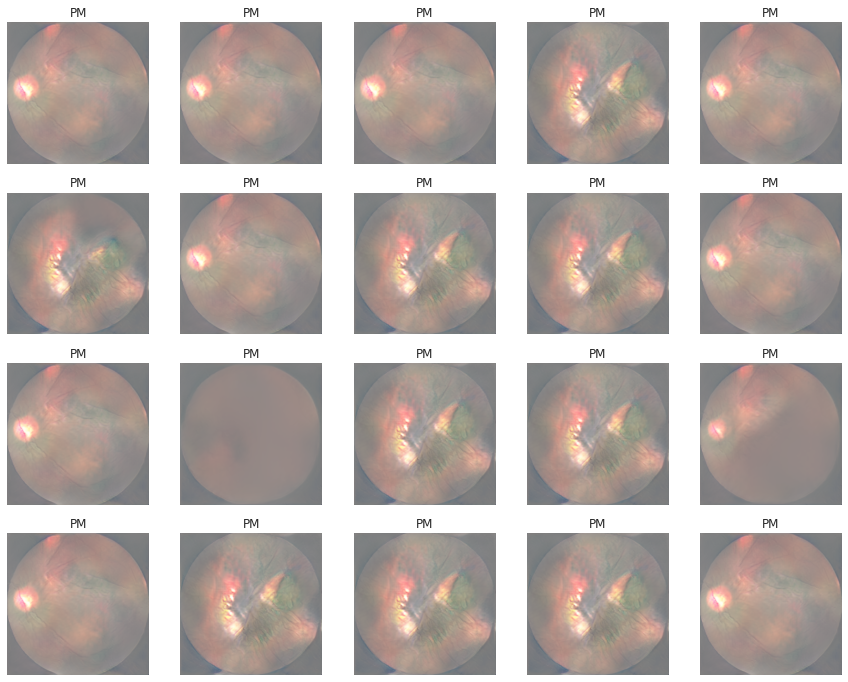

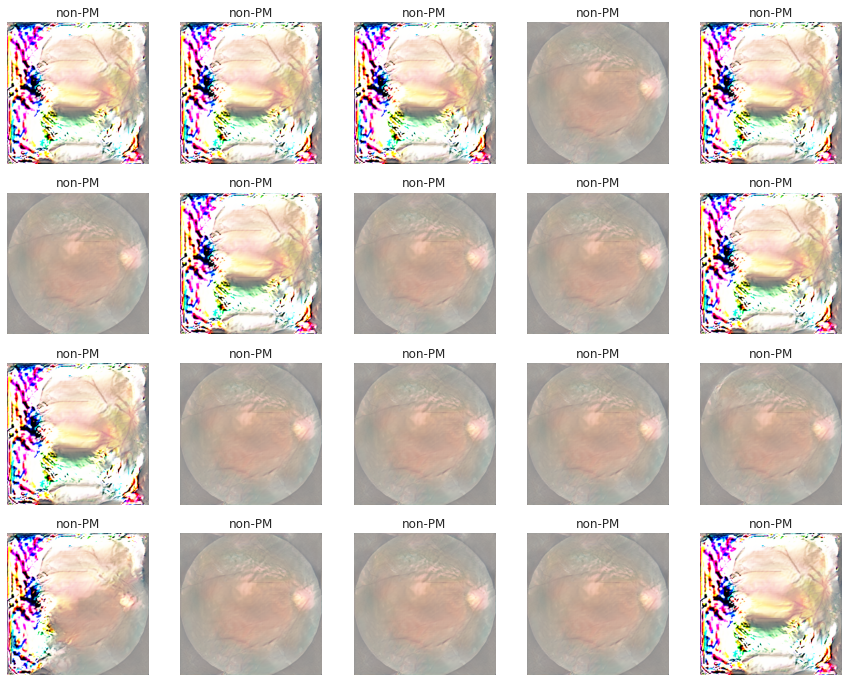

Epoch 11/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.020     gen_loss=31.958     t=1063s
Epoch 12/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.102     gen_loss=32.021     t=1065s
Epoch 13/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.220     gen_loss=32.440     t=1064s
Epoch 14/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.036     gen_loss=31.797     t=1066s
Epoch 15/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.152     gen_loss=32.056     t=1064s
Epoch 16/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.050     gen_loss=31.837     t=1065s
Epoch 17/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.019     gen_loss=31.846     t=1068s
Epoch 18/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.063     gen_loss=31.886     t=1070s
Epoch 19/225     lr_g=6.0e-03   

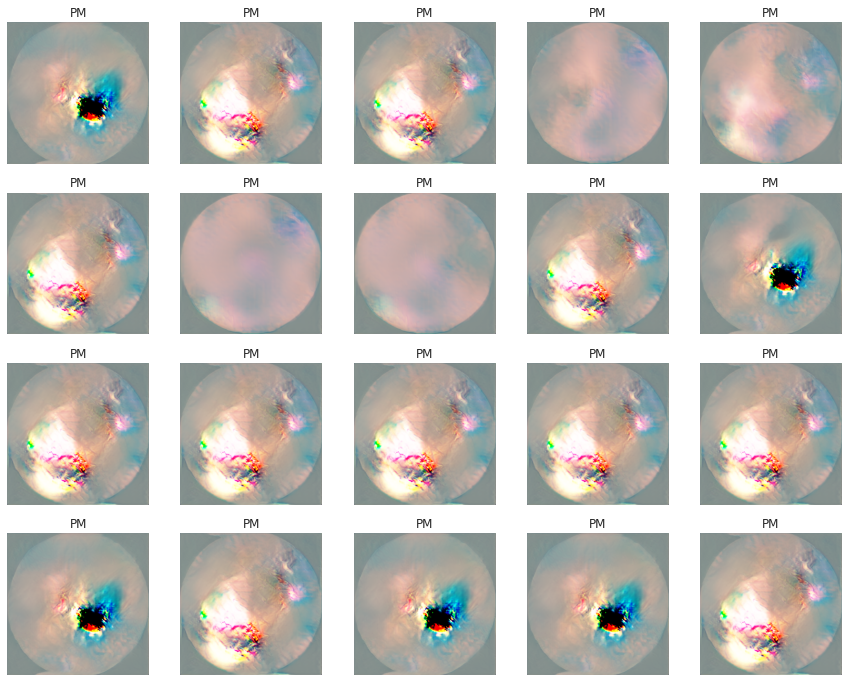

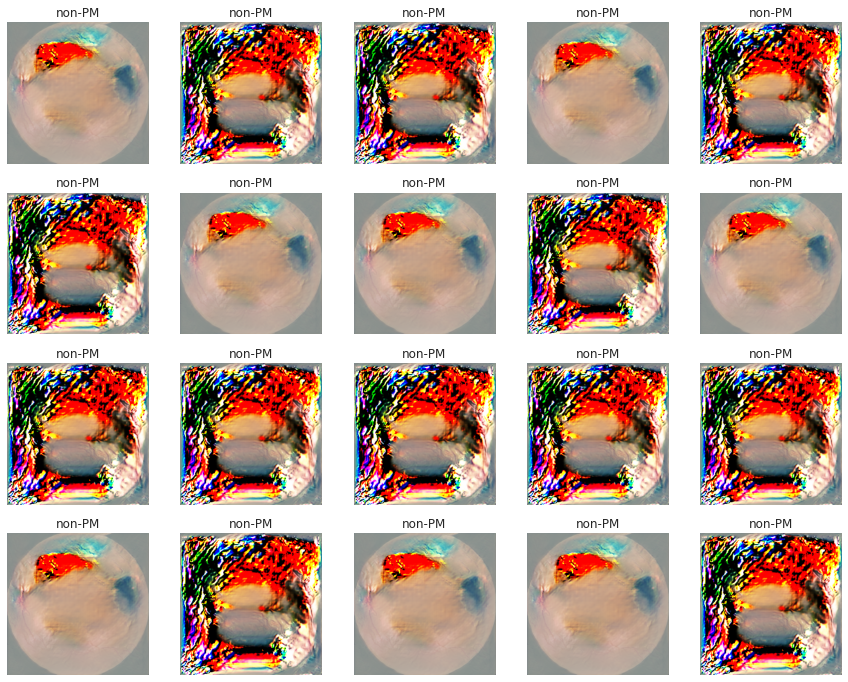

Epoch 21/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.074     gen_loss=31.902     t=1065s
Epoch 22/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.787     gen_loss=32.587     t=1068s
Epoch 23/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.464     gen_loss=32.716     t=1064s
Epoch 24/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=18.993     gen_loss=31.714     t=1068s
Epoch 25/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.412     gen_loss=31.858     t=1066s
Epoch 26/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=20.751     gen_loss=32.174     t=1068s
Epoch 27/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.024     gen_loss=31.836     t=1066s
Epoch 28/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.035     gen_loss=31.565     t=1068s
Epoch 29/225     lr_g=6.0e-03   

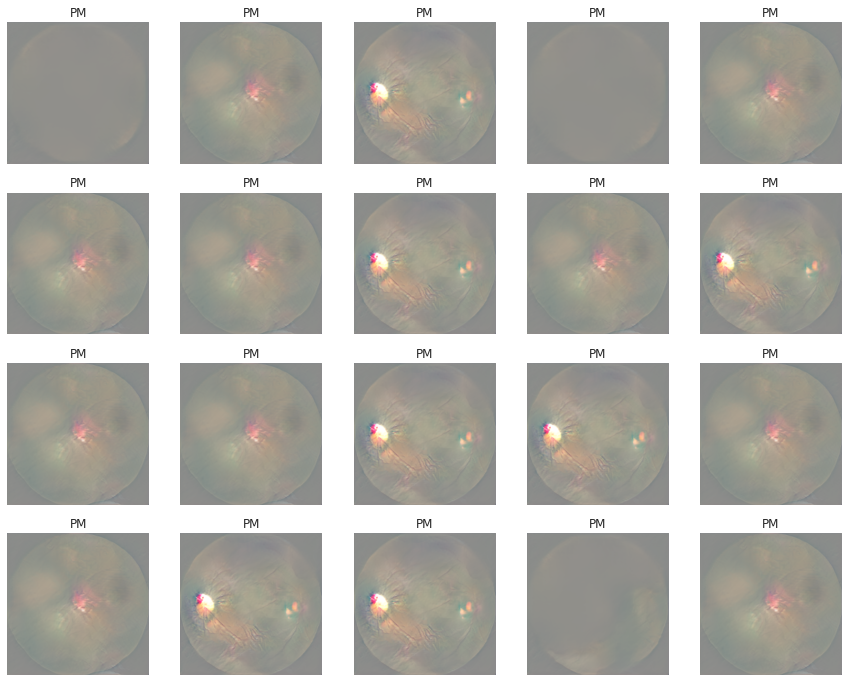

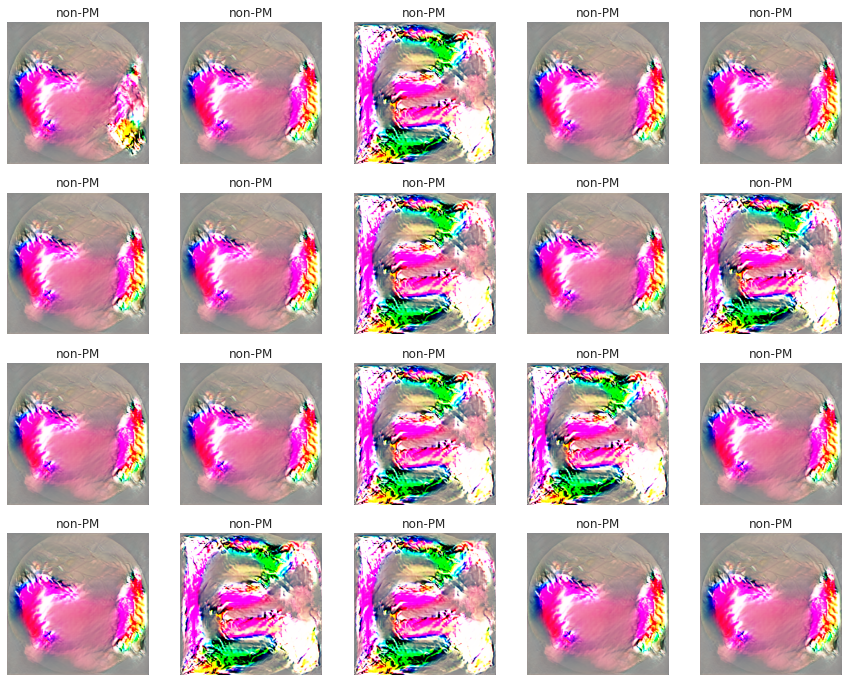

Epoch 31/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.040     gen_loss=31.778     t=1071s
Epoch 32/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=18.979     gen_loss=31.794     t=1071s
Epoch 33/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.030     gen_loss=31.855     t=1070s
Epoch 34/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=18.987     gen_loss=31.737     t=1071s
Epoch 35/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.485     gen_loss=32.681     t=1070s
Epoch 36/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.933     gen_loss=32.010     t=1070s
Epoch 37/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.387     gen_loss=31.617     t=1067s
Epoch 38/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=20.441     gen_loss=32.091     t=1070s
Epoch 39/225     lr_g=6.0e-03   

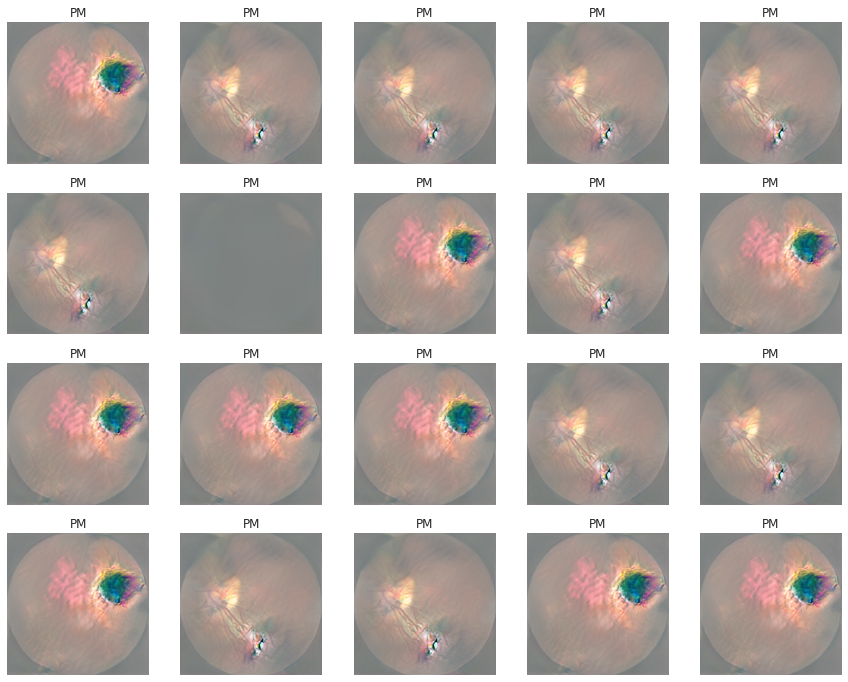

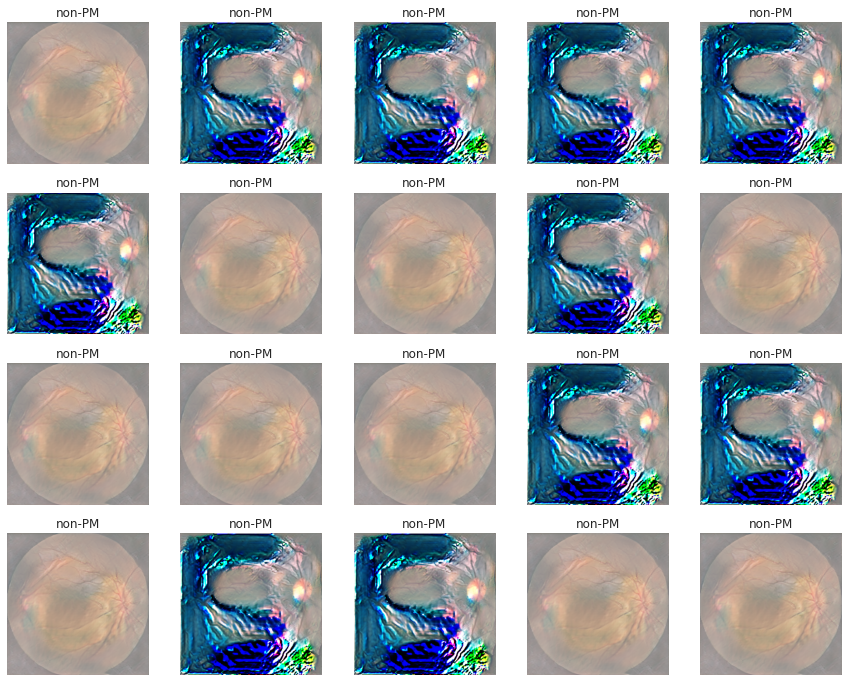

Epoch 41/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.057     gen_loss=31.653     t=1073s
Epoch 42/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.452     gen_loss=32.274     t=1073s
Epoch 43/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.849     gen_loss=31.684     t=1070s
Epoch 44/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=21.549     gen_loss=35.993     t=1071s
Epoch 45/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=22.127     gen_loss=32.790     t=1074s
Epoch 46/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=20.310     gen_loss=32.874     t=1072s
Epoch 47/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.021     gen_loss=31.924     t=1069s
Epoch 48/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.825     gen_loss=32.520     t=1073s
Epoch 49/225     lr_g=6.0e-03   

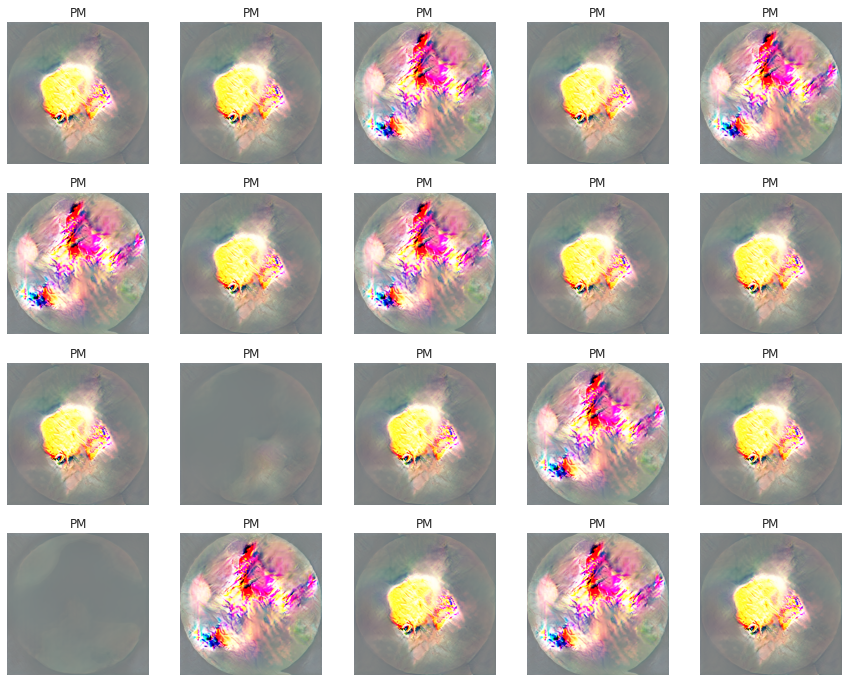

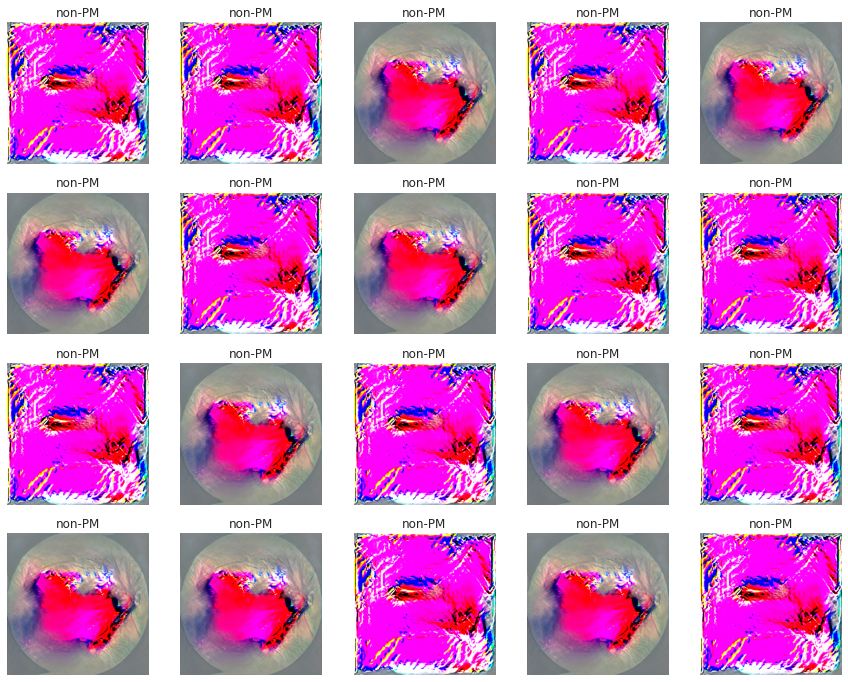

Epoch 51/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=19.044     gen_loss=31.856     t=1066s
Epoch 52/225     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=18.974     gen_loss=31.767     t=1070s


In [ ]:
infos = pro_gan.train(
    dataset=dataset,
    epochs=num_epochs,
    fade_in_percentage=fade_ins,
    batch_sizes=batch_sizes,
    ema_decays=ema_decays,
    verbose=1
)

In [ ]:
#seed_everything(seed)
_ = pro_gan.generate(noise=th.randn(batch_sizes[0], 256 - 2).cuda(), races=torch.from_numpy(np.random.choice([1], size=batch_sizes[0])).long(), n=batch_sizes[0], n_plot=10)



True
699


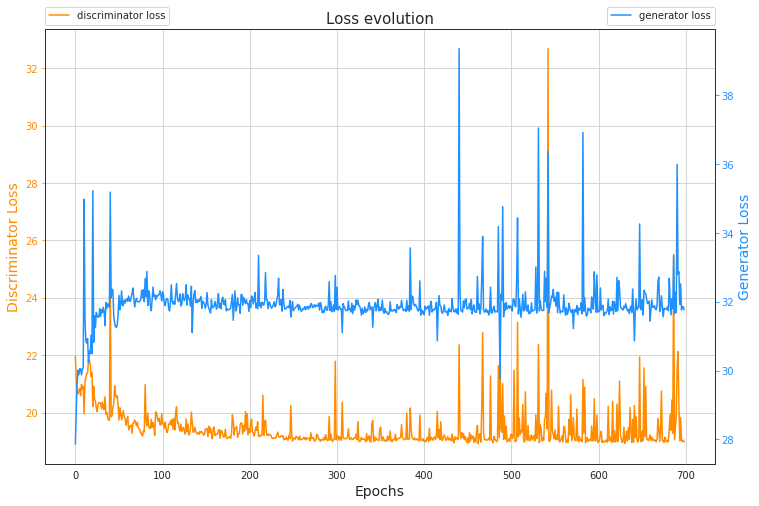

In [ ]:
# REPASAR
dis_loss = [21.960, 21.174, 20.704, 20.657, 20.771, 20.840, 20.589, 20.989, 20.819, 20.917, 19.960, 21.097, 21.212, 21.363, 21.372, 21.827, 21.832, 21.686, 21.254, 21.391,
            20.206, 20.918, 20.470, 20.403, 20.152, 20.035, 20.266, 20.351, 20.330, 20.335, 20.131, 20.370, 20.165, 20.103, 20.552, 19.944, 20.007, 19.842, 19.737, 19.741,
            24.777, 19.857, 19.889, 20.187, 20.303, 20.935, 20.615, 20.526, 20.591, 20.262, 19.740, 20.168, 19.983, 19.752, 19.897, 20.066, 19.858, 19.808, 19.562, 19.737,
            19.865, 19.405, 19.511, 19.544, 19.565, 19.279, 19.639, 19.642, 19.744, 19.672, 19.538, 19.667, 19.489, 19.427, 19.411, 19.269, 19.271, 19.183, 19.373, 19.330,
            20.973, 19.738, 19.539, 19.985, 19.525, 19.456, 19.449, 19.761, 19.486, 19.659, 19.508, 19.213, 20.027, 20.001, 19.828, 19.700, 19.803, 19.575, 19.569, 19.965,
            19.606, 19.625, 19.450, 19.680, 19.454, 19.309, 19.379, 19.602, 19.598, 19.708, 19.560, 19.766, 19.418, 19.800, 19.399, 20.007, 20.201, 19.641, 19.668, 19.456,
            19.362, 19.596, 19.353, 19.461, 19.486, 19.336, 19.250, 19.780, 19.336, 19.594, 19.228, 19.287, 19.445, 20.016, 19.663, 19.310, 19.340, 19.491, 19.338, 19.277,
            19.250, 19.314, 19.249, 19.345, 19.299, 19.339, 19.292, 19.219, 19.237, 19.418, 19.431, 19.448, 19.157, 19.528, 19.303, 19.466, 19.251, 19.085, 19.427, 19.503,
            19.205, 19.267, 19.244, 19.252, 19.375, 19.409, 19.107, 19.374, 19.359, 19.240, 19.139, 19.179, 19.423, 19.145, 19.095, 19.135, 19.136, 19.170, 19.101, 19.275,
            19.922, 19.730, 19.217, 19.448, 19.488, 19.509, 19.144, 19.257, 19.260, 19.573, 19.650, 19.629, 19.255, 19.553, 19.353, 20.042, 19.421, 19.968, 19.230, 19.446,
            19.307, 19.620, 19.773, 19.328, 19.286, 19.184, 19.341, 19.504, 19.386, 19.677, 19.179, 19.208, 19.165, 19.226, 19.233, 20.613, 19.202, 19.626, 19.736, 19.288,
            19.199, 19.257, 19.212, 19.227, 19.220, 19.137, 19.101, 19.110, 19.129, 19.104, 19.133, 19.223, 19.319, 19.156, 19.143, 19.144, 19.192, 19.167, 19.198, 19.056,
            19.088, 19.075, 19.156, 19.051, 19.043, 19.205, 19.095, 20.244, 19.273, 19.009, 19.108, 19.112, 19.073, 19.169, 19.150, 19.113, 19.052, 19.184, 19.064, 19.056,
            19.070, 19.092, 19.144, 19.070, 19.135, 19.059, 19.111, 19.107, 19.101, 19.020, 19.298, 19.092, 19.120, 19.123, 19.005, 19.027, 19.086, 19.242, 19.201, 19.060,
            19.069, 19.000, 19.057, 19.060, 19.036, 19.133, 19.051, 19.231, 19.087, 19.026, 19.038, 19.866, 19.041, 19.262, 19.060, 18.988, 19.065, 19.089, 21.792, 19.054,
            19.180, 19.182, 19.044, 19.163, 19.123, 19.037, 20.368, 19.142, 19.086, 19.099, 19.096, 19.090, 19.145, 19.436, 19.092, 19.055, 19.129, 19.090, 19.064, 19.090,
            19.120, 19.119, 19.248, 19.062, 19.691, 19.024, 18.989, 19.028, 19.131, 19.064, 19.087, 19.088, 19.051, 18.982, 19.268, 19.029, 19.124, 19.196, 18.982, 18.981,
            19.624, 19.728, 18.991, 19.165, 19.026, 19.113, 19.060, 19.044, 19.027, 19.412, 19.497, 19.022, 19.146, 19.149, 19.015, 19.006, 19.046, 18.999, 19.190, 19.071,
            19.035, 19.362, 19.018, 18.981, 19.052, 19.070, 19.047, 19.243, 19.022, 19.076, 19.084, 19.109, 19.114, 19.151, 19.588, 19.130, 19.094, 19.051, 19.085, 19.072,
            19.977, 19.068, 19.086, 19.081, 20.162, 19.404, 19.154, 19.090, 19.060, 19.121, 19.049, 19.069, 19.092, 19.031, 19.015, 19.9192, 19.051, 19.040, 19.035, 19.091,
            18.986, 19.007, 18.992, 19.101, 19.143, 19.004, 19.458, 19.042, 19.137, 19.097, 19.038, 19.121, 19.152, 19.071, 19.253, 20.034, 19.120, 19.416, 19.057, 19.686,
            19.075, 19.024, 19.143, 19.226, 19.118, 19.032, 19.070, 19.167, 19.052, 19.096, 19.088, 19.022, 19.261, 19.027, 18.952, 19.157, 19.067, 19.119, 19.118, 19.066,
            22.361, 19.329, 19.086, 19.303, 19.131, 19.271, 19.058, 19.168, 19.047, 18.965, 19.120, 18.947, 19.307, 19.020, 19.218, 19.096, 19.186, 18.967, 19.115, 18.979,
            19.321, 19.553, 18.906, 19.211, 19.267, 18.972, 20.255, 22.787, 19.309, 19.058, 19.069, 19.041, 19.042, 19.071, 19.111, 19.043, 21.277, 19.052, 19.042, 18.947,
            19.174, 19.091, 19.034, 18.982, 19.034, 21.637, 19.128, 22.168, 19.401, 19.316, 21.008, 19.064, 19.884, 19.084, 19.528, 18.985, 19.013, 19.083, 18.999, 19.185,
            19.250, 19.099, 19.154, 21.482, 18.996, 19.002, 19.033, 23.147, 19.162, 19.815, 19.240, 19.378, 19.316, 20.289, 19.028, 18.973, 20.727, 19.063, 19.044, 19.550,
            19.043, 19.011, 19.151, 19.218, 19.046, 19.144, 19.200, 19.018, 19.929, 19.091, 19.258, 22.374, 18.955, 19.575, 19.454, 19.007, 19.115, 19.039, 19.765, 19.866,
            20.672, 19.432, 32.683, 18.997, 19.013, 19.102, 20.785, 19.377, 19.218, 19.091, 19.402, 19.061, 19.191, 19.051, 20.227, 18.977, 18.998, 19.080, 19.188, 18.986,
            19.521, 19.506, 19.096, 18.946, 19.046, 18.969, 19.769, 19.220, 20.625, 19.028, 19.178, 19.830, 19.160, 19.034, 19.020, 20.125, 19.061, 18.983, 19.175, 19.021,
            19.066, 18.981, 21.156, 19.283, 20.888, 18.951, 19.007, 19.134, 18.996, 19.056, 19.062, 19.018, 19.538, 19.014, 19.051, 20.483, 19.010, 19.040, 19.919, 18.961,
            19.008, 19.027, 19.250, 19.351, 18.959, 19.020, 18.980, 18.971, 19.026, 19.046, 18.971, 20.221, 19.015, 19.023, 19.156, 18.969, 20.399, 18.983, 19.366, 18.975,
            19.015, 20.297, 18.989, 19.712, 21.090, 19.191, 19.097, 18.954, 19.010, 19.495, 18.926, 19.051, 19.356, 19.005, 19.479, 19.075, 20.176, 19.368, 18.962, 19.768,
            18.972, 20.251, 19.137, 19.854, 19.046, 18.973, 19.135, 21.940, 19.007, 18.984, 19.368, 19.019, 21.557, 19.166, 20.909, 19.081, 19.071, 19.020, 19.102, 19.220,
            19.036, 19.152, 19.050, 19.019, 19.063, 19.012, 18.982, 19.074, 19.787, 19.464, 18.993, 19.412, 20.751, 19.024, 19.035, 18.961, 19.145, 19.040, 18.979, 19.030,
            18.987, 19.485, 19.933, 19.387, 20.441, 19.283, 25.511, 19.057, 19.452, 19.849, 21.549, 22.127, 20.310, 19.021, 19.825, 19.029, 18.992, 19.044, 18.974]

gen_loss = [27.868, 28.857, 29.628, 30.011, 29.879, 30.059, 30.052, 29.876, 30.041, 30.067, 34.975, 31.490, 30.861, 30.797, 30.931, 30.243, 30.567, 30.493, 31.033, 30.496,
            35.223, 30.824, 31.597, 31.250, 31.691, 31.610, 31.547, 31.559, 31.807, 31.577, 31.773, 31.679, 31.841, 31.714, 31.306, 31.977, 31.803, 31.941, 31.918, 31.843,
            35.185, 32.118, 32.360, 32.351, 31.580, 31.392, 31.275, 31.257, 31.320, 31.645, 32.186, 31.763, 31.948, 32.318, 31.883, 31.903, 32.049, 31.963, 32.052, 32.085,
            32.008, 32.166, 32.051, 32.010, 32.133, 32.253, 32.400, 32.093, 31.847, 32.030, 32.103, 32.004, 32.000, 31.993, 32.031, 32.046, 32.335, 32.128, 32.352, 32.004,
            32.676, 32.145, 32.881, 31.893, 32.318, 32.238, 31.884, 31.739, 32.064, 32.431, 32.148, 32.201, 32.058, 32.173, 32.147, 32.201, 32.203, 32.319, 32.210, 32.026,
            32.291, 32.191, 31.962, 31.883, 32.048, 32.095, 32.066, 31.805, 31.733, 32.027, 32.490, 32.010, 31.932, 32.017, 31.928, 32.231, 32.529, 32.128, 32.006, 32.027,
            32.226, 31.877, 31.921, 32.232, 32.096, 32.028, 32.118, 32.492, 31.905, 32.195, 32.090, 32.094, 31.876, 32.451, 31.102, 31.968, 32.229, 32.323, 31.976, 32.065,
            31.975, 32.048, 32.010, 32.095, 32.147, 31.811, 32.025, 31.975, 31.931, 31.811, 31.936, 32.268, 31.904, 31.805, 31.753, 31.675, 32.057, 31.821, 31.848, 31.857,
            32.013, 31.874, 31.787, 31.993, 32.239, 31.828, 31.951, 31.794, 32.060, 32.129, 31.941, 31.909, 32.059, 31.738, 31.797, 31.768, 31.767, 31.793, 31.810, 32.014,
            32.210, 31.461, 31.905, 32.317, 31.733, 31.835, 32.114, 31.910, 31.915, 31.664, 32.208, 32.206, 31.897, 32.127, 32.038, 31.945, 32.063, 31.950, 31.944, 31.720,
            32.029, 31.835, 32.167, 32.126, 31.934, 32.075, 32.268, 31.819, 31.956, 31.797, 33.350, 31.878, 31.969, 31.819, 31.990, 31.938, 31.899, 32.014, 32.850, 32.060,
            32.053, 31.797, 31.991, 31.974, 31.852, 31.813, 31.858, 31.906, 31.999, 31.854, 31.894, 32.063, 32.182, 32.682, 31.916, 31.909, 32.066, 31.727, 32.357, 31.952,
            31.796, 31.792, 31.815, 31.861, 31.870, 31.824, 32.036, 31.559, 31.827, 32.007, 31.736, 31.793, 31.825, 31.855, 31.871, 31.930, 31.763, 31.898, 31.805, 31.718,
            31.756, 31.805, 31.787, 31.860, 31.766, 31.854, 31.850, 31.784, 31.871, 31.824, 31.947, 31.927, 31.832, 31.848, 31.913, 31.856, 31.903, 31.871, 31.888, 31.960,
            31.757, 31.975, 31.894, 31.683, 31.737, 31.689, 31.820, 31.871, 31.750, 31.759, 31.914, 32.583, 31.744, 32.004, 31.707, 31.769, 31.909, 31.717, 32.763, 31.779,
            32.419, 31.757, 31.856, 31.854, 31.775, 31.793, 31.104, 31.947, 31.863, 31.812, 31.747, 31.744, 31.743, 32.025, 31.769, 31.798, 31.704, 31.956, 31.655, 31.892,
            31.758, 31.834, 32.056, 31.922, 32.043, 31.879, 31.871, 31.786, 31.613, 31.813, 31.654, 31.717, 31.850, 31.690, 31.776, 31.736, 31.904, 31.980, 31.770, 31.831,
            31.854, 31.261, 31.806, 31.873, 31.975, 31.735, 31.874, 32.073, 31.733, 31.845, 31.742, 31.790, 32.050, 31.719, 31.666, 31.809, 31.694, 31.712, 31.648, 31.633,
            31.680, 32.001, 31.729, 31.754, 31.729, 31.773, 31.741, 31.770, 31.683, 31.916, 31.835, 31.789, 31.861, 31.829, 32.039, 31.859, 31.740, 31.762, 31.782, 31.719,
            32.045, 31.759, 31.879, 31.723, 33.565, 31.778, 32.162, 32.145, 31.924, 31.877, 31.921, 31.865, 31.791, 31.730, 31.754, 32.608, 31.609, 31.763, 31.666, 31.720,
            31.623, 31.873, 31.792, 31.794, 31.865, 31.874, 31.606, 31.923, 32.014, 31.704, 31.762, 31.759, 31.811, 31.793, 31.984, 30.867, 31.814, 32.179, 31.897, 31.867,
            31.703, 31.663, 31.749, 31.908, 31.710, 31.703, 31.727, 31.606, 31.805, 31.718, 31.750, 31.705, 32.091, 31.814, 31.715, 31.707, 31.790, 31.676, 31.794, 31.635,
            39.350, 32.265, 31.739, 31.740, 31.700, 32.026, 31.825, 32.063, 32.085, 31.791, 31.803, 31.832, 31.953, 31.768, 32.066, 31.645, 31.798, 31.906, 31.716, 31.692,
            31.697, 32.740, 31.779, 31.939, 31.650, 31.835, 32.700, 33.899, 31.772, 31.698, 31.716, 31.793, 31.696, 31.745, 31.617, 31.702, 32.424, 31.682, 31.669, 31.796,
            31.871, 31.698, 31.725, 31.714, 31.704, 34.182, 31.598, 29.762, 32.223, 32.044, 34.763, 31.564, 31.947, 31.746, 31.986, 31.791, 31.840, 31.887, 31.810, 31.878,
            31.833, 31.731, 32.085, 32.071, 31.887, 31.855, 32.624, 34.439, 31.644, 32.094, 31.830, 31.548, 31.797, 32.215, 31.740, 31.741, 32.284, 31.796, 31.726, 31.905,
            31.654, 31.701, 31.676, 31.969, 31.725, 31.745, 31.750, 31.771, 33.012, 31.674, 32.035, 37.046, 31.735, 32.034, 31.823, 31.748, 31.745, 31.743, 32.890, 32.008,
            32.685, 31.839, 36.360, 31.684, 31.847, 31.975, 32.165, 32.133, 32.356, 32.019, 32.127, 31.875, 32.276, 31.682, 32.275, 31.866, 31.670, 31.732, 31.713, 31.709,
            32.199, 31.821, 31.609, 31.825, 31.631, 31.705, 31.956, 31.798, 31.707, 31.688, 31.780, 31.221, 31.762, 31.774, 31.700, 31.890, 31.624, 31.824, 31.759, 31.765,
            31.974, 31.651, 36.915, 31.727, 32.121, 31.723, 31.582, 31.635, 31.814, 31.754, 31.793, 31.677, 32.138, 31.814, 31.786, 32.868, 32.161, 31.698, 32.780, 31.697,
            31.731, 31.723, 32.403, 31.758, 31.875, 31.897, 31.598, 31.673, 31.653, 31.708, 31.755, 32.081, 31.630, 31.854, 31.740, 31.755, 32.017, 31.642, 32.002, 31.828,
            31.712, 32.708, 31.738, 32.613, 32.349, 31.861, 31.809, 31.783, 31.762, 31.869, 31.821, 31.944, 31.844, 31.738, 31.782, 31.659, 31.787, 31.872, 31.689, 32.372,
            31.790, 30.865, 31.744, 32.086, 31.767, 31.836, 31.838, 34.260, 31.784, 31.770, 32.059, 31.615, 32.331, 32.254, 32.227, 32.085, 31.948, 31.958, 32.021, 31.440,
            31.797, 32.056, 31.837, 31.846, 31.886, 31.787, 31.768, 31.902, 32.587, 32.716, 31.714, 31.858, 32.174, 31.836, 31.565, 31.811, 31.800, 31.778, 31.794, 31.855,
            31.737, 32.681, 32.010, 31.617, 32.091, 31.797, 33.343, 31.653, 32.274, 31.684, 35.993, 32.790, 32.874, 31.924, 32.520, 31.760, 31.860, 31.856, 31.767]
print(len(dis_loss)==len(gen_loss))
print(len(dis_loss))

num_epochs = [10, 10, 20, 40, 100, 200, 500, 1000]
# para mostrar sólo una resolución
#dis_loss = dis_loss[180:]
#gen_loss = gen_loss[180:]

fig, ax1 = plt.subplots(figsize=(12, 8))

plt.plot(dis_loss, label='discriminator loss', c='darkorange')
ax1.set_ylabel('Discriminator Loss', color='darkorange', size=14)
ax1.tick_params(axis='y', colors='darkorange')
ax1.set_xlabel('Epochs', size=14)
plt.grid(True)
plt.legend(loc=(0, 1.01))

ax2 = ax1.twinx()
plt.plot(gen_loss, label='generator loss', c='dodgerblue')
ax2.set_ylabel('Generator Loss', color='dodgerblue', size=14)
ax2.tick_params(axis='y', colors='dodgerblue')
plt.legend(loc=(0.84, 1.01))
'''
res = 4
for epoch in np.cumsum(num_epochs[:-1]):
    plt.axvline(epoch, c='r', alpha=0.5)
    plt.text(x=epoch-10, y=np.max(gen_loss), s=f'{res}x{res}', bbox=dict(facecolor='red', alpha=0.25))
    res *= 2
'''
plt.title('Loss evolution', size=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2 [00:00<?, ?it/s]

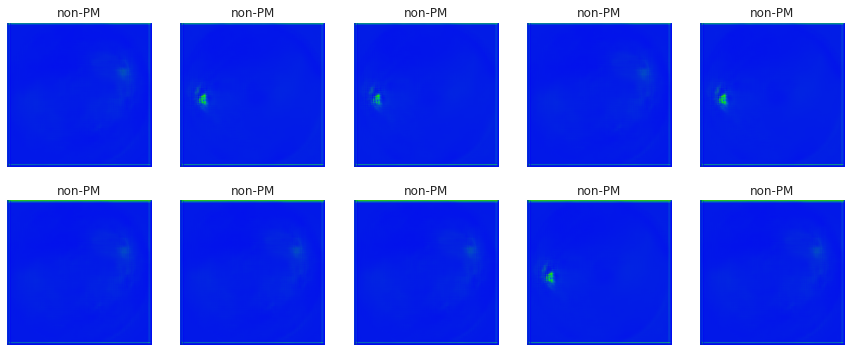

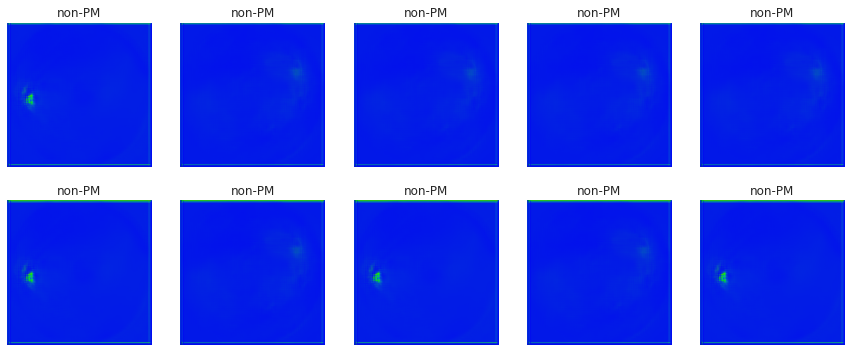

In [ ]:
use_class_probs = False
im_batch_size = 10
n_images = 20
for i_batch in tqdm(range(0, n_images, im_batch_size)):
    if use_class_probs:
        races = np.random.choice(kept_classes, size=im_batch_size, p=probs)
        races = torch.from_numpy(races).long()
        gen_images = pro_gan.generate(races=races, n=im_batch_size)
    else:
        #gen_images = pro_gan.generate(n=im_batch_size)
        gen_images = pro_gan.generate(noise=th.randn(im_batch_size, 256 - 2).cuda(), races=torch.from_numpy(np.random.choice([1], size=im_batch_size)).long(), n=im_batch_size, n_plot=10)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/drive/My Drive/Colab Notebooks/TFG/images/output1/', f'img_{i_batch+i_image}.png'))
